## Harmonic Regression Baseline

https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy

In [7]:


import sys
sys.path.append('..')
from dataset import ModisDataset

import numpy as np
from scipy.optimize import leastsq
import pylab as plt
import sklearn.metrics

dataset = ModisDataset(region="germany",
                       fold="test",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=False,
                       filter_date=(None,None))

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz


In [8]:
def fit_harmonic_regression(data, t):

    guess_mean = np.mean(data)
    guess_std = 1.5#3*np.std(data)/(2**0.5)/(2**0.5)
    guess_phase = -1
    guess_freq = 1
    guess_amp = 1.5

    # we'll use this to plot our first estimate. This might already be good enough for you
    data_first_guess = guess_amp*np.sin(t+guess_phase) + guess_mean

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    return est_amp, est_freq, est_phase, est_mean

def plot_harmonic_regression(data,t,params):
    est_amp, est_freq, est_phase, est_mean = params
    # recreate the fitted curve using the optimized parameters
    data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

    # recreate the fitted curve using the optimized parameters

    fine_t = np.arange(min(t),max(t),0.1)
    data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

    fig,ax = plt.subplots(figsize=(12,4))
    ax.plot(t, data)
    #ax.plot(t, data_first_guess, label='first guess')
    ax.plot(fine_t, data_fit, label='after fitting')
    ax.legend()
    plt.show()
    

In [18]:
from tqdm import tqdm

def predict(t, params):
    est_amp, est_freq, est_phase, est_mean = params
    # recreate the fitted curve using the optimized parameters
    return est_amp*np.sin(est_freq*t+est_phase) + est_mean

idx = 0
split_idx = np.where(dataset.date[0].astype(str) == "2010-01-01")[0][0]
    
    
true = list()
pred = list()
for idx in tqdm(range(dataset.data.shape[0])):

    data = dataset.data[idx,:,0]
    
    dstd = dataset.std
    dmean = dataset.mean
    data = (data * dstd) + dmean
    data = data*1e-4
    
    t = np.linspace(0, 20*2*np.pi, data.shape[0])

    fit_data = data[:split_idx]
    fit_t = t[:split_idx]
    test_data = data[split_idx:]
    test_t = t[split_idx:]

    params = fit_harmonic_regression(fit_data, fit_t)
    #plot_harmonic_regression(test_data,test_t,params)

    data_pred = predict(test_t, params)

    true.append(test_data)
    pred.append(data_pred)
    
true = np.stack(true)
pred = np.stack(pred)

100%|██████████| 200/200 [00:00<00:00, 2002.58it/s]


## Total Metrics

In [19]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def calc_metrics(true, pred):
    mae = sklearn.metrics.mean_absolute_error(true,pred)
    mse = sklearn.metrics.mean_squared_error(true,pred)
    r2 = sklearn.metrics.r2_score(true,pred)
    return mae, mse, r2

def calc_dtw(true,pred):
    distances = list()
    for idx in range(true.shape[0]):
        dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
        distances.append(dtw)
    return np.array(distances).mean()

mae, mse, r2 = calc_metrics(true.reshape(-1), pred.reshape(-1))
dtw = calc_dtw(true, pred)

print(f"MAE {mae:.4f}, MSE {mse:.4f}, R2 {r2:.4f}, DTW {dtw:.4f}")

MAE 0.1349, MSE 0.0312, R2 0.4139, DTW 24.5847


In [30]:
import pandas as pd

metrics = list()
for idx in tqdm(range(200)):
    mae, mse, r2 = calc_metrics(true[idx], pred[idx])
    dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
    metrics.append([idx,mae,mse,r2,dtw])
    #print(f"idx {idx}, MAE {mae:.4f}, MSE {mse:.4f}, R2 {r2:.4f}, DTW {dtw:.4f}")
results = pd.DataFrame(metrics,columns=["idx","mae","mse","r2","dtw"]).set_index('idx')

100%|██████████| 200/200 [00:08<00:00, 22.84it/s]


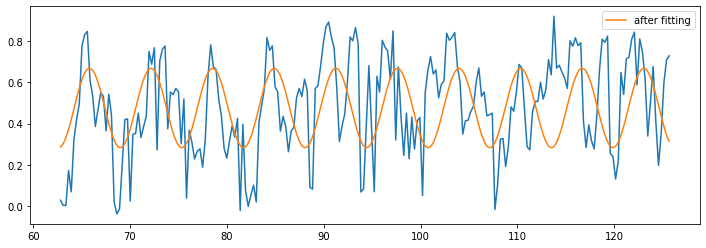

idx 94: MAE 0.1937, MSE 0.0510, R2 0.1937


In [50]:
idx = 94

data = dataset.data[idx,:,0]

dstd = dataset.std
dmean = dataset.mean
data = (data * dstd) + dmean
data = data*1e-4

t = np.linspace(0, 20*2*np.pi, data.shape[0])

fit_data = data[:split_idx]
fit_t = t[:split_idx]
test_data = data[split_idx:]
test_t = t[split_idx:]

params = fit_harmonic_regression(fit_data, fit_t)

data_pred = predict(test_t, params)

plot_harmonic_regression(test_data,test_t,params)
mae, mse, r2 = calc_metrics(test_data, data_pred)
print(f"idx {idx}: MAE {mae:.4f}, MSE {mse:.4f}, R2 {mae:.4f}")

/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


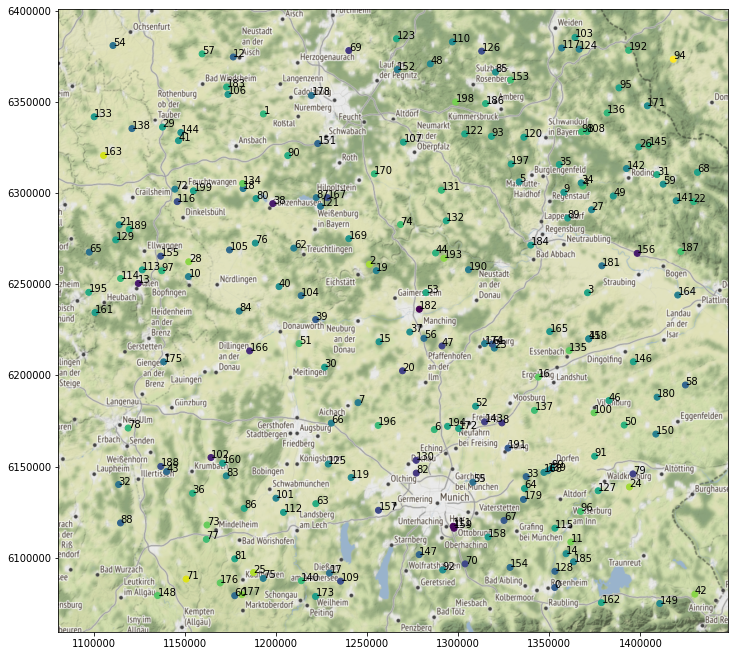

In [49]:
import geopandas as gpd
import contextily as ctx

gdf = gpd.GeoDataFrame(dataset.meta, geometry=gpd.points_from_xy(dataset.meta.x, dataset.meta.y),crs=4326).to_crs(epsg=3857)
gdf = pd.concat([gdf.reset_index(),results.reset_index()],axis=1)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

    
fig,ax = plt.subplots(figsize=(12,12))
#gdf.plot(column="mse",ax=ax)
ax.scatter(gdf.geometry.x,gdf.geometry.y,c=gdf.mse)

for idx, row in gdf.iterrows():
    ax.annotate(s=f"{row.idx}", xy=(row.geometry.x,row.geometry.y))

url = "http://a.tile.stamen.com/terrain/tileZ/tileX/tileY.png"
add_basemap(ax,9,url)

In [39]:
results.mse.median()

0.03188536393969987

In [41]:
results.mse.mean()

0.031210762311611902